# import packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
# Text representation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# ML Algo
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# Evaluvation
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report

from time import time

In [ ]:
import string
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer

In [ ]:
def plotConfusionMatrixHeatmap(input_df: pd.core.frame.DataFrame, model_name: str, figsize=(20, 18)):
    """
    Return the results of a multiclass classification algorithms as a heatmap
    based on a confusion matrix.        
    """
    # Heatmap of the results
    plt.figure(figsize=figsize)
    sns.heatmap(input_df, annot=True, fmt='d', cmap='Reds')
    plt.ylabel('True', fontweight='bold')
    plt.xlabel('Predicted', fontweight='bold')
    plt.title(f'Confusion Matrix - {model_name}', size=14, fontweight='bold')
    plt.show()

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# Load Trianing file

In [ ]:
data_path = 'drive/MyDrive/Springboard/data/loan_data_train.csv'

In [ ]:
df = pd.read_csv(data_path)

In [ ]:
df.shape

(40715, 4)

In [ ]:
df.columns

Index(['Unnamed: 0', 'index', 'full_text', 'label'], dtype='object')

In [ ]:
df.head()

,Unnamed: 0,index,full_text,label
0,0,26,Problem with a credit reporting company's inve...,Vehicle loan or lease
1,1,141,I purchased a vehicle 3 years ago. As of recen...,Vehicle loan or lease
2,2,179,Great Lakes sent my account to a loan service ...,Student loan
3,3,185,Problems at the end of the loan or lease-Termi...,Vehicle loan or lease
4,4,203,Incorrect information on your report-Account s...,Student loan


In [ ]:
df.drop(columns=['Unnamed: 0', 'index'], inplace=True)

In [ ]:
df.columns

Index(['full_text', 'label'], dtype='object')

In [ ]:
df.head()

,full_text,label
0,Problem with a credit reporting company's inve...,Vehicle loan or lease
1,I purchased a vehicle 3 years ago. As of recen...,Vehicle loan or lease
2,Great Lakes sent my account to a loan service ...,Student loan
3,Problems at the end of the loan or lease-Termi...,Vehicle loan or lease
4,Incorrect information on your report-Account s...,Student loan


In [ ]:
df['label'].value_counts()

Student loan                                 19131
Vehicle loan or lease                         7838
Consumer Loan                                 6659
Payday loan, title loan, or personal loan     5873
Payday loan                                   1214
Name: label, dtype: int64

In [ ]:
# Class distribution
df['label'].value_counts()/df.shape[0] * 100

Student loan                                 46.987597
Vehicle loan or lease                        19.250890
Consumer Loan                                16.355152
Payday loan, title loan, or personal loan    14.424659
Payday loan                                   2.981702
Name: label, dtype: float64

# Pre Processing

In [ ]:
def clean_text(doc):
    """
      1. Converting all text into lower case
      2. Removing classified words like xxx
      3. Remove stop words
      4. remove punctuation
      5. remove digits
      6. Wordnet lemmatizer
      7. Custom regex for further cleaning
      """
    # Set stop word as english
    stop_word = set(stopwords.words('english'))
    
    # Tokenize the sentence and make all character lower case
    doc = [x.lower() for x in word_tokenize(doc)]
    
    # Remove classified texts
    doc = [x for x in doc if x.lower() != 'xxxx' and x.lower() != 'xx' 
           and x.lower() != 'xx/xx/xxxx' and x.lower() != 'xxxx/xxxx/xxxx']
    
    # Remove stop words
    doc = [x for x in doc if x not in stop_word]
    
    # Remove Punctuation
    doc = [x for x in doc if x not in string.punctuation]
    
    # Remove Digits
    doc = [x for x in doc if not x.isdigit()]
    
    # Set NLTK Wordnet lemmatizer and lemmatize the sentence
    lemmatizer = WordNetLemmatizer()
    doc = " ".join([lemmatizer.lemmatize(word) for word in doc])

    # Regular expression to remove unwanted chars
    pattern_1 = re.compile(r"(\W)|(\d)")
    pattern_2 = re.compile(r"\s\s+")

    doc = pattern_1.sub(" ", doc)
    doc = pattern_2.sub("", doc)
    
    return doc

In [ ]:
df['text_processed'] = df.apply(lambda row : clean_text(row['full_text']), axis = 1)

In [ ]:
df.head()

,full_text,label,text_processed
0,Problem with a credit reporting company's inve...,Vehicle loan or lease,problem credit reporting companys investigatio...
1,I purchased a vehicle 3 years ago. As of recen...,Vehicle loan or lease,purchased vehicle year ago recentlyve made eve...
2,Great Lakes sent my account to a loan service ...,Student loan,great lake sent account loan service group nam...
3,Problems at the end of the loan or lease-Termi...,Vehicle loan or lease,problem end loan lease termination fee problem...
4,Incorrect information on your report-Account s...,Student loan,incorrect information report account status in...


In [ ]:
df.reset_index(inplace=True)

# Encoding and Modeling

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [ ]:
df['label'] = df['label'].replace(['Payday loan'],'Payday loan, title loan, or personal loan')

In [ ]:
df['label_id'] = label_encoder.fit_transform(df['label'])

In [ ]:
# Put the label category into dict for future use
label_map = df.set_index('label_id').to_dict()['label']
label_map

{0: 'Consumer Loan',
 1: 'Payday loan, title loan, or personal loan',
 2: 'Student loan',
 3: 'Vehicle loan or lease'}

In [ ]:
df.head()

,index,full_text,label,text_processed,label_id
0,0,Problem with a credit reporting company's inve...,Vehicle loan or lease,problem credit reporting companys investigatio...,3
1,1,I purchased a vehicle 3 years ago. As of recen...,Vehicle loan or lease,purchased vehicle year ago recentlyve made eve...,3
2,2,Great Lakes sent my account to a loan service ...,Student loan,great lake sent account loan service group nam...,2
3,3,Problems at the end of the loan or lease-Termi...,Vehicle loan or lease,problem end loan lease termination fee problem...,3
4,4,Incorrect information on your report-Account s...,Student loan,incorrect information report account status in...,2


In [ ]:
X = df.text_processed
y = df.label_id

In [ ]:
print(X.shape, y.shape)

(40715,) (40715,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(30536,) (30536,)
(10179,) (10179,)


# Multinomial Naive bayes

In [ ]:
# Parameter values to test
param_grid = {
    'TfIdf__max_features' : [10000, 20000, 25000, 30000],
    'TfIdf__ngram_range' : [(1,1),(1,2),(2,2)],
    'TfIdf__use_idf' : [True],
    'MultinomialNB__alpha' : [0.01, 0.02, 0.05, 0.10]
    }

In [ ]:
# Creating pipeline for Naive Bayes Model
pipeline_mnb = Pipeline(steps = [('TfIdf', TfidfVectorizer()),
                              ('MultinomialNB', MultinomialNB())])

In [ ]:
grid_search_mnb = GridSearchCV(pipeline_mnb, param_grid, cv=5, verbose=1, n_jobs=10)

In [ ]:
grid_search_mnb.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  2.5min
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed: 13.9min
[Parallel(n_jobs=10)]: Done 240 out of 240 | elapsed: 18.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('TfIdf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        n

In [ ]:
print(grid_search_mnb.best_params_)

{'MultinomialNB__alpha': 0.1, 'TfIdf__max_features': 25000, 'TfIdf__ngram_range': (1, 2), 'TfIdf__use_idf': True}


In [ ]:
print(grid_search_mnb.best_estimator_)

Pipeline(memory=None,
         steps=[('TfIdf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=25000,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('MultinomialNB',
                 MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True))],
         verbose=False)


In [ ]:
grid_search_mnb.score(X_test, y_test)

0.7754199823165341

In [ ]:
y_predicted = grid_search_mnb.predict(X_test)

In [ ]:
classification_report_mnb = classification_report(y_test, y_predicted)
print(classification_report_mnb)

              precision    recall  f1-score   support

           0       0.54      0.33      0.41      1693
           1       0.70      0.72      0.71      1738
           2       0.92      0.96      0.94      4813
           3       0.63      0.76      0.69      1935

    accuracy                           0.78     10179
   macro avg       0.70      0.69      0.69     10179
weighted avg       0.76      0.78      0.76     10179



In [ ]:
key_to_label_name = [x[1] for x in sorted(label_map.items())]

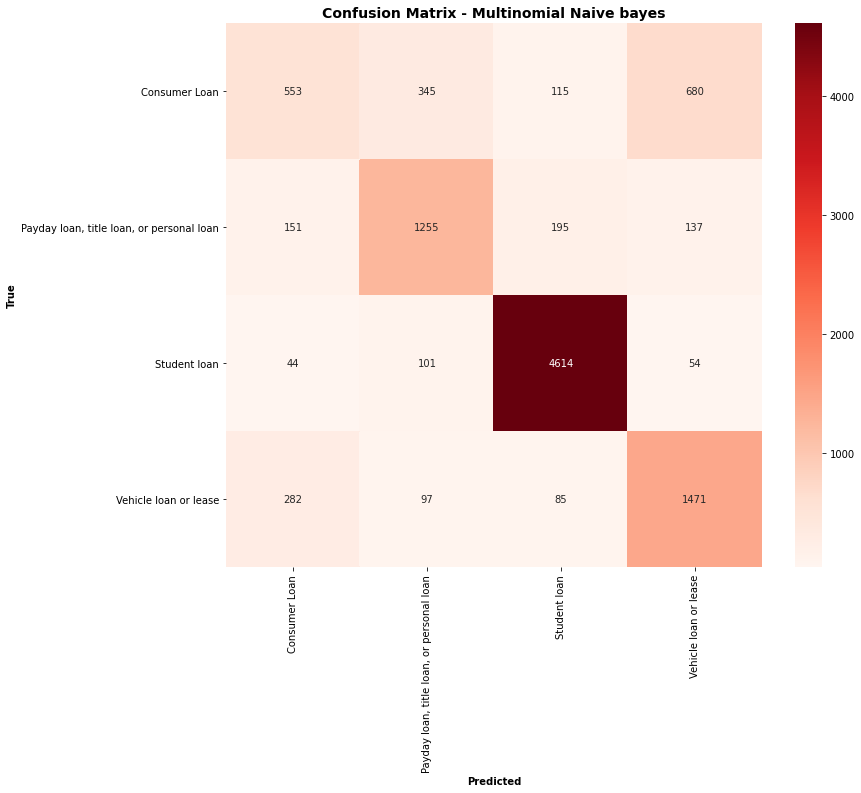

In [ ]:
conf_matrix_df = pd.DataFrame(data=confusion_matrix(y_test, y_predicted),
                              index=key_to_label_name, columns=key_to_label_name)

plotConfusionMatrixHeatmap(conf_matrix_df, model_name='Multinomial Naive bayes', figsize=(12, 10))

In [ ]:
import joblib

In [ ]:
joblib.dump(grid_search_mnb.best_estimator_, 'drive/MyDrive/Springboard/data/models/Multinomial_naive_bayes_with_loan_data.pkl', compress = 1)

['drive/MyDrive/Springboard/data/models/Multinomial_naive_bayes_with_loan_data.pkl']

# Logistic Regression

In [ ]:
param_grid_lr = {
    'TfIdf__max_features' : [10000, 20000, 25000, 30000],
    'TfIdf__ngram_range' : [(1,1),(1,2),(2,2)],
    'TfIdf__use_idf' : [True]
    }

In [ ]:
# Creating pipeline for Logistice Regression model
pipeline_lr = Pipeline(steps = [('TfIdf', TfidfVectorizer()),
                              ('LogisticRegression', LogisticRegression(class_weight="balanced"))])

In [ ]:
grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=5, verbose=1, n_jobs=10)

In [ ]:
grid_search_lr.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  3.9min
[Parallel(n_jobs=10)]: Done  60 out of  60 | elapsed:  8.0min finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('TfIdf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        n

In [ ]:
print(grid_search_lr.best_params_)

{'TfIdf__max_features': 30000, 'TfIdf__ngram_range': (1, 2), 'TfIdf__use_idf': True}


In [ ]:
print(grid_search_lr.best_estimator_)

Pipeline(memory=None,
         steps=[('TfIdf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=30000,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('LogisticRegression',
                 LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                                    fit_intercept=T

In [ ]:
grid_search_lr.score(X_test, y_test)

0.7817074368798507

In [ ]:
y_predicted = grid_search_lr.predict(X_test)

In [ ]:
classification_report_lr = classification_report(y_test, y_predicted)
print(classification_report_lr)

              precision    recall  f1-score   support

           0       0.52      0.47      0.50      1693
           1       0.66      0.80      0.72      1738
           2       0.98      0.92      0.95      4813
           3       0.66      0.69      0.67      1935

    accuracy                           0.78     10179
   macro avg       0.71      0.72      0.71     10179
weighted avg       0.79      0.78      0.78     10179



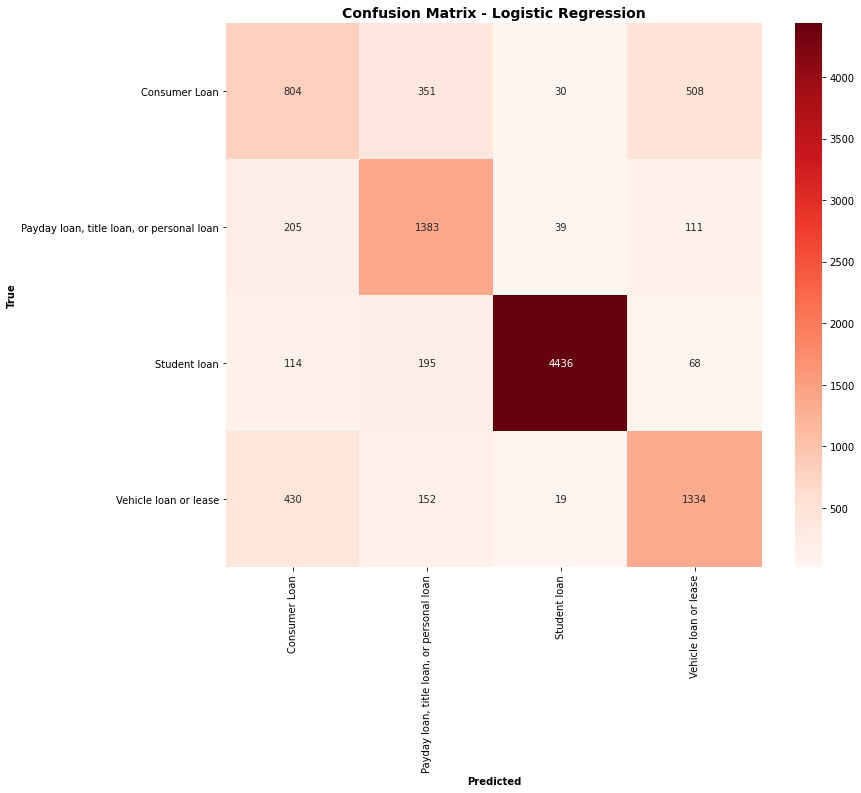

In [ ]:
conf_matrix_df = pd.DataFrame(data=confusion_matrix(y_test, y_predicted),
                              index=key_to_label_name, columns=key_to_label_name)

plotConfusionMatrixHeatmap(conf_matrix_df, model_name='Logistic Regression', figsize=(12, 10))

In [ ]:
joblib.dump(grid_search_lr.best_estimator_, 'drive/MyDrive/Springboard/data/models/logistic_regression_with_loan_data.pkl', compress = 1)

['drive/MyDrive/Springboard/data/models/logistic_regression_with_loan_data.pkl']

# Random forest clasifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
vectorizer = TfidfVectorizer(min_df=3, stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 2))

In [ ]:
pipeline_rf = Pipeline(steps = [('countvectorizer', vectorizer),
                              ('clf', RandomForestClassifier())])

In [ ]:
model = pipeline_rf.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred_prob = model.predict_proba(X_test)

In [ ]:
lr_probs = y_pred_prob[:,1]

In [ ]:
accuracy_score(y_test, y_pred)

0.7487965418999902

In [ ]:
conf_matrix_df = pd.DataFrame(data=confusion_matrix(y_test, y_pred),index=key_to_label_name,
                              columns=key_to_label_name)

In [ ]:
classification_rep = classification_report(y_test, y_pred,target_names=key_to_label_name)
print(classification_rep)

                                           precision    recall  f1-score   support

                            Consumer Loan       0.55      0.14      0.23      1693
Payday loan, title loan, or personal loan       0.69      0.68      0.68      1738
                             Student loan       0.86      0.97      0.91      4813
                    Vehicle loan or lease       0.59      0.78      0.67      1935

                                 accuracy                           0.75     10179
                                macro avg       0.67      0.64      0.62     10179
                             weighted avg       0.73      0.75      0.71     10179



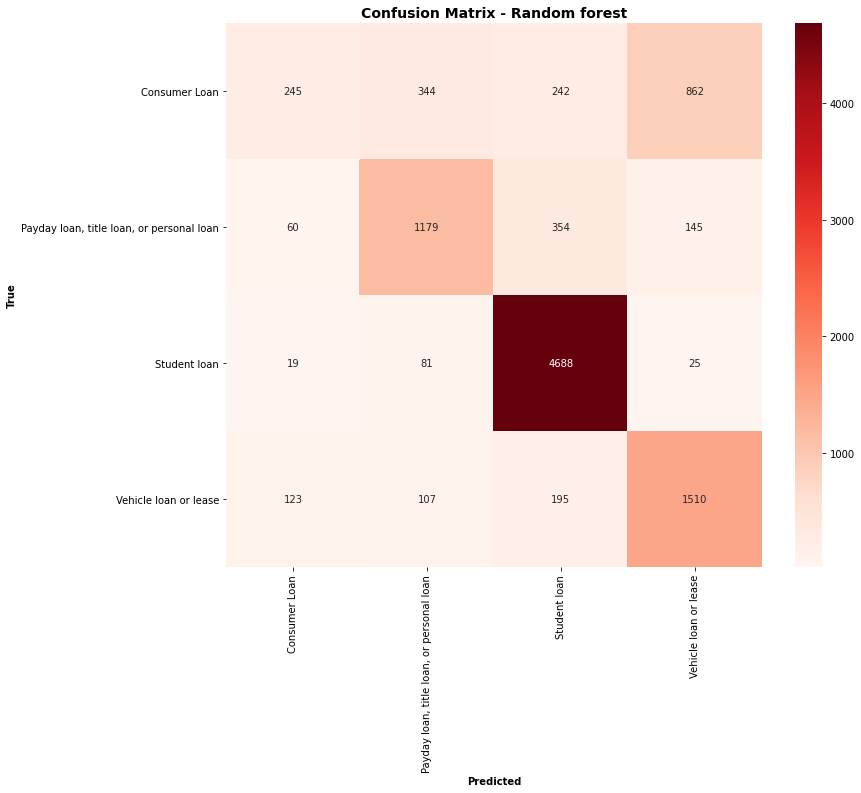

In [ ]:
plotConfusionMatrixHeatmap(conf_matrix_df, model_name='Random forest', figsize=(12, 10))

In [ ]:
joblib.dump(model, 'drive/MyDrive/Springboard/data/models/random_forest_with_loan_data.pkl', compress = 1)

['drive/MyDrive/Springboard/data/models/random_forest_with_loan_data.pkl']

# Doc 2 Vec with logistic regression

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [ ]:
#prepare training data in doc2vec format:
train_doc2vec = [TaggedDocument((d), tags=[str(i)]) for i, d in enumerate(X_train)]

In [ ]:
train_doc2vec

In [ ]:
#Train a doc2vec model to learn
model = Doc2Vec(vector_size=50, alpha=0.025, min_count=5, dm =1, epochs=100)
model.build_vocab(train_doc2vec)
model.train(train_doc2vec, total_examples=model.corpus_count, epochs=model.epochs)
model.save("drive/MyDrive/Springboard/data/models/d2v_loan.model")
print("Model Saved")

Model Saved


In [ ]:
#Infer the feature representation for training and test data using the trained model
model= Doc2Vec.load("drive/MyDrive/Springboard/data/models/d2v_loan.model")

In [ ]:
#infer in multiple steps to get a stable representation. 
train_vectors =  [model.infer_vector(list_of_tokens, steps=50) for list_of_tokens in X_train]
test_vectors = [model.infer_vector(list_of_tokens, steps=50) for list_of_tokens in X_test]

In [ ]:
clf = LogisticRegression(class_weight="balanced")
clf.fit(train_vectors, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
preds = clf.predict(test_vectors)

In [ ]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.27      0.25      0.26      1693
           1       0.30      0.41      0.34      1738
           2       0.71      0.60      0.65      4813
           3       0.36      0.39      0.37      1935

    accuracy                           0.47     10179
   macro avg       0.41      0.41      0.41     10179
weighted avg       0.50      0.47      0.48     10179



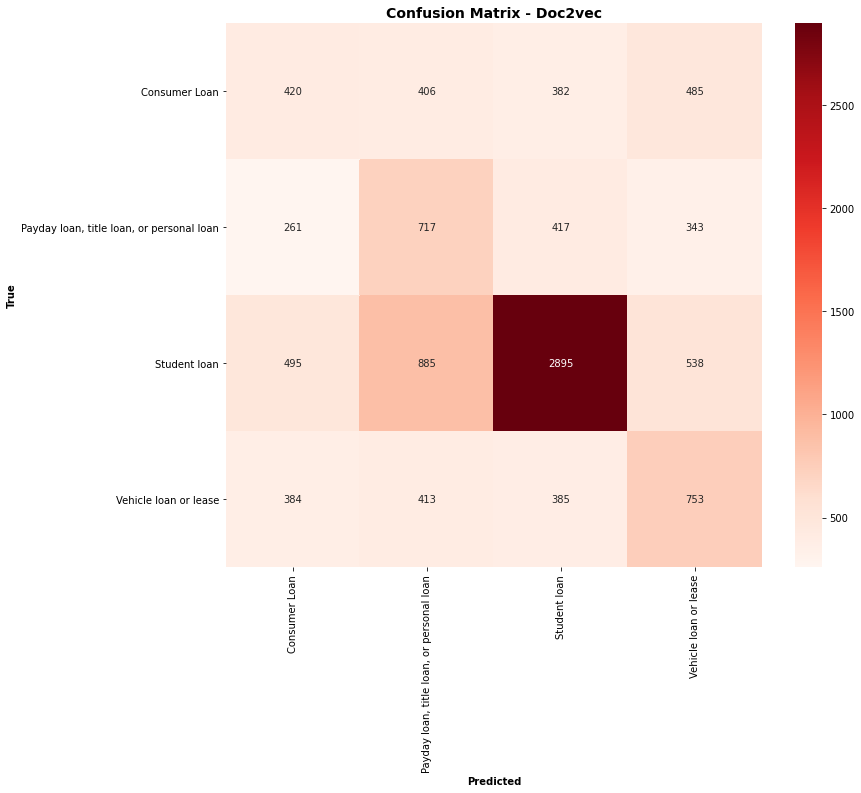

In [ ]:
conf_matrix_df = pd.DataFrame(data=confusion_matrix(y_test, preds),
                              index=key_to_label_name, columns=key_to_label_name)

plotConfusionMatrixHeatmap(conf_matrix_df, model_name='Doc2vec', figsize=(12, 10))

In [ ]:
joblib.dump(clf, 'drive/MyDrive/Springboard/data/models/logistic_doc2vec_with_loan_data.pkl', compress = 1)

['drive/MyDrive/Springboard/data/models/logistic_doc2vec_with_loan_data.pkl']

# Deep Learning

In [ ]:
# Necessary Imports
import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM
from keras.models import Model, Sequential
from keras.initializers import Constant

In [ ]:
# Download GloVe word embedding
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2021-01-22 10:46:42--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-01-22 10:46:42--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-01-22 10:46:42--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
# Unzip it
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
!pwd

/content


In [ ]:
glove_dir = 'glove'

In [ ]:
max_sequence_length = 1000
max_num_words = 20000
embedding_dim = 200
validation_split = 0.2

In [ ]:
train_texts = df['text_processed']

In [ ]:
train_texts = train_texts.to_list()

In [ ]:
train_labels = df['label_id']

In [ ]:
train_labels = train_labels.to_list()

In [ ]:
type(train_texts)

list

In [ ]:
type(train_labels)

list

In [ ]:
train_texts[0]

'problem credit reporting companys investigation existing problem their investigation fix error report'

In [ ]:
train_labels[0]

3

In [ ]:
# Vectorize the text sample into 2D integer tensor using keras Tokenizer
# Tokenizer will fir only on training data and transform both train and test data

tokenizer = Tokenizer(num_words=max_num_words)

tokenizer.fit_on_texts(train_texts)

train_sequences = tokenizer.texts_to_sequences(train_texts)
word_index = tokenizer.word_index


In [ ]:
print(len(train_sequences[0]))

12


In [ ]:
print(len(train_sequences[24999]))

152


In [ ]:
word_index["after"]

4720

In [ ]:
# Converting this to sequences to be fed into neural network. Max seq. len is 1000 as set earlier
# initial padding of 0s, until vector is of size MAX_SEQUENCE_LENGTH

# Pad_squences is ot make all the samples in same length.
# Sequences that are shorter than num_timesteps are padded with value until they are num_timesteps long. 
# Sequences longer than num_timesteps are truncated so that they fit the desired length.

train_valid_data = pad_sequences(train_sequences, maxlen=max_sequence_length)
train_valid_labels = to_categorical(np.asarray(train_labels))


In [ ]:
print(train_valid_data.shape)

(40715, 1000)


In [ ]:
# spliting trainig set and validation set
indices = np.arange(train_valid_data.shape[0]) # Return evenly spaced values within a given interval.
np.random.shuffle(indices) # Modify a sequence in-place by shuffling its contents.

train_valid_data = train_valid_data[indices]
train_valid_labels = train_valid_labels[indices]

In [ ]:
num_validation_samples = int(validation_split * train_valid_data.shape[0])

print(num_validation_samples)

8143


In [ ]:
X_train = train_valid_data[:-num_validation_samples]
y_train = train_valid_labels[:-num_validation_samples]
X_val = train_valid_data[-num_validation_samples:]
y_val = train_valid_labels[-num_validation_samples:]

In [ ]:
print(X_train.shape, y_train.shape)

(32572, 1000) (32572, 4)


In [ ]:
# build index mapping words in the embeddings set to their embedding vector
embeddings_index = {}

with open('glove.6B.200d.txt') as f:
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs


print('Found %s word vectors in Glove embeddings.' % len(embeddings_index))

Found 400000 word vectors in Glove embeddings.


In [ ]:
print(embeddings_index["cube"])

[ 0.095789  -0.46755   -0.4109     0.23223    0.52719    0.2036
  0.17575   -0.16305   -0.59678   -0.57058   -0.40217    0.2804
  0.40405    0.2731    -0.36563    0.071209  -0.37869   -0.116
  0.17491    0.27384   -0.74331    0.22654    0.10123   -0.61351
  0.041468   0.29191    0.43205   -0.8113    -0.5454     0.38612
 -0.091256  -0.13519   -0.34071   -0.13824   -0.15446    0.12083
 -0.33084   -1.0632     0.062599   0.11213   -0.53525    0.099355
  0.71156    0.45348   -0.11641    0.68769   -0.45519   -0.25393
  0.0074914  0.28983   -0.009376   0.42163   -0.63396   -0.035484
  0.60248    0.26093   -0.092479   0.15043    0.072953  -0.48143
 -0.57987    0.24628   -0.9747    -0.1702     0.34789   -0.22117
 -0.51841    0.23377    0.51891    0.42052    0.23693    0.26471
  0.18427    0.03566   -0.17597    0.19796    0.69339   -0.37217
 -0.531      0.024534  -0.096397  -0.4331    -0.30723   -1.0936
  0.47536   -0.32422    0.31672    0.70839    0.1111    -0.76518
  0.04056    0.23401   -0.00

In [ ]:
# prepare embedding matrix - rows are the words from word_index, columns are the embeddings of that word from glove.

num_words = min(max_num_words, len(word_index)) + 1

embedding_matrix = np.zeros((num_words, embedding_dim)) # Return a new array of given shape and type, filled with zeros.

for word, i in word_index.items():
  if i > max_num_words:
    continue
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    # words not found in embedding index will be all zeros
    embedding_matrix[i] = embedding_vector

In [ ]:
# Loading pre-trained word embedding into an embedding layer

embedding_layer = Embedding(num_words, embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=max_sequence_length,
                            trainable=False)

In [ ]:
label_index = {'Consumer Loan': 0,'Payday loan, title loan, or personal loan' : 1,'Student loan': 2,'Vehicle loan or lease': 3}

# Test file load

In [ ]:
test_data_path = 'drive/MyDrive/Springboard/data/loan_data_test.csv'

In [ ]:
test_data = pd.read_csv(test_data_path)

In [ ]:
test_data.drop(columns=['Unnamed: 0', 'index'], inplace=True)

In [ ]:
test_data.head()

,full_text,label
0,Hi my names is XXXX XXXX and I 'm very upset w...,Consumer Loan
1,Company attorney claims they have tried to con...,"Payday loan, title loan, or personal loan"
2,Purchased my car from CARVANA XX/XX/XXXX. \nTe...,Vehicle loan or lease
3,"I have XXXX loans ( we 'll call them the "" XXX...",Student loan
4,XX/XX/XXXX : Paid my lease as agreed. \nXX/XX/...,Consumer Loan


In [ ]:
test_data['text_processed'] = test_data.apply(lambda row : clean_text(row['full_text']), axis = 1)

In [ ]:
test_data['label'] = test_data['label'].replace(['Payday loan'],'Payday loan, title loan, or personal loan')

In [ ]:
test_data['label_id'] = label_encoder.fit_transform(test_data['label'])

In [ ]:
test_data.head()

,full_text,label,text_processed,label_id
0,Hi my names is XXXX XXXX and I 'm very upset w...,Consumer Loan,hi namem upset regional acceptance corporation...,0
1,Company attorney claims they have tried to con...,"Payday loan, title loan, or personal loan",company attorney claim tried contact never rec...,1
2,Purchased my car from CARVANA XX/XX/XXXX. \nTe...,Vehicle loan or lease,purchased car carvana temp tag expired im driv...,3
3,"I have XXXX loans ( we 'll call them the "" XXX...",Student loan,loanll callloan sallie mae currentlyre account...,2
4,XX/XX/XXXX : Paid my lease as agreed. \nXX/XX/...,Consumer Loan,paid lease agreed acquired new car dealership ...,0


In [ ]:
test_texts = test_data['text_processed']

In [ ]:
test_texts = test_texts.to_list()

In [ ]:
test_labels = test_data['label_id']

In [ ]:
test_labels = test_labels.to_list()

In [ ]:
test_texts[0]

'hi namem upset regional acceptance corporation charged beginning n t fixed problem payment told payment would n t close car warranty charged another warranty n t need among thing promised would get spear tire still n t one need cause attend college never know happen want payment reasonable like told purchased car also applied gap insurance car knowledge'

In [ ]:
test_sequences = tokenizer.texts_to_sequences(test_texts)

In [ ]:
test_data = pad_sequences(test_sequences, maxlen=max_sequence_length)
test_labels = to_categorical(np.asarray(test_labels))

# 1D CNN Model with pre-trained embedding

In [ ]:
cnn = Sequential()
cnn.add(embedding_layer)
cnn.add(Conv1D(128, 5, activation='relu'))
cnn.add(MaxPooling1D(5))
cnn.add(Conv1D(128, 5, activation='relu'))
cnn.add(MaxPooling1D(5))
cnn.add(Conv1D(128, 5, activation='relu'))
cnn.add(GlobalMaxPooling1D())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dense(len(label_index), activation='softmax'))

cnn.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [ ]:
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 200)         4000200   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 996, 128)          128128    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 35, 128)           82048     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)              

In [ ]:
#Train the model. Tune to validation set. 
cnn.fit(X_train, y_train, batch_size=128, epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
255/255 [==============================] - 24s 63ms/step - loss: 0.9474 - acc: 0.5920 - val_loss: 0.6656 - val_acc: 0.6991
Epoch 2/5
255/255 [==============================] - 16s 62ms/step - loss: 0.5757 - acc: 0.7400 - val_loss: 0.5700 - val_acc: 0.7440
Epoch 3/5
255/255 [==============================] - 16s 61ms/step - loss: 0.5025 - acc: 0.7792 - val_loss: 0.5986 - val_acc: 0.7428
Epoch 4/5
255/255 [==============================] - 15s 61ms/step - loss: 0.4204 - acc: 0.8200 - val_loss: 0.6933 - val_acc: 0.7031
Epoch 5/5
255/255 [==============================] - 15s 61ms/step - loss: 0.3682 - acc: 0.8415 - val_loss: 0.6367 - val_acc: 0.7462


In [ ]:
#Evaluate on test set:
score, acc = cnn.evaluate(test_data, test_labels)
print('Test accuracy with CNN:', acc)

546/546 [==============================] - 6s 11ms/step - loss: 0.6044 - acc: 0.7567
Test accuracy with CNN: 0.7566622495651245


In [ ]:
cnn.save("drive/MyDrive/Springboard/data/models/1D_CNN_model_with_pre_trained_embedding.h5")

# 1D CNN model with training own embedding

In [ ]:
print("Defining and training a CNN model, training embedding layer on the fly instead of using pre-trained embeddings")
cnnmodel = Sequential()
cnnmodel.add(Embedding(max_num_words, 128))
cnnmodel.add(Conv1D(128, 5, activation='relu'))
cnnmodel.add(MaxPooling1D(5))
cnnmodel.add(Conv1D(128, 5, activation='relu'))
cnnmodel.add(MaxPooling1D(5))
cnnmodel.add(Conv1D(128, 5, activation='relu'))
cnnmodel.add(GlobalMaxPooling1D())
cnnmodel.add(Dense(128, activation='relu'))
cnnmodel.add(Dense(len(label_index), activation='softmax'))

cnnmodel.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

Defining and training a CNN model, training embedding layer on the fly instead of using pre-trained embeddings


In [ ]:
cnnmodel.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
conv1d_12 (Conv1D)           (None, None, 128)         82048     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, None, 128)         82048     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, None, 128)         82048     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)              

In [ ]:
#Train the model. Tune to validation set. 
cnnmodel.fit(X_train, y_train,
          batch_size=128,
          epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
255/255 [==============================] - 20s 76ms/step - loss: 0.8373 - acc: 0.6220 - val_loss: 0.5698 - val_acc: 0.7492
Epoch 2/5
255/255 [==============================] - 19s 74ms/step - loss: 0.4982 - acc: 0.7730 - val_loss: 0.5017 - val_acc: 0.7732
Epoch 3/5
255/255 [==============================] - 19s 74ms/step - loss: 0.4317 - acc: 0.8021 - val_loss: 0.5148 - val_acc: 0.7647
Epoch 4/5
255/255 [==============================] - 19s 74ms/step - loss: 0.3801 - acc: 0.8260 - val_loss: 0.6457 - val_acc: 0.7511
Epoch 5/5
255/255 [==============================] - 19s 74ms/step - loss: 0.2946 - acc: 0.8763 - val_loss: 0.6608 - val_acc: 0.7228


In [ ]:
#Evaluate on test set:
score, acc = cnnmodel.evaluate(test_data, test_labels)
print('Test accuracy with CNN:', acc)

546/546 [==============================] - 4s 8ms/step - loss: 0.6688 - acc: 0.7220
Test accuracy with CNN: 0.7219898104667664


In [ ]:
cnnmodel.save("drive/MyDrive/Springboard/data/models/1D_CNN_model_with_training_own_embedding.h5")